In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import os


In [4]:
# Image size and batch size
image_size = (380, 380)
batch_size = 64

### Load the folder and label

In [5]:
# The main folder
# base_path = "/Users/mrbinit/Downloads/preprocessed/"
base_path = "/content/drive/My Drive/preprocessed"

# Create list of file paths and corresponding labels
file_paths = []
labels = []

# Iterate through 'fake' and 'real' subfolders to collect file paths and labels
for label, category in enumerate(['fake', 'real']):
    category_path = os.path.join(base_path, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(label)  # Assign label 0 for 'fake' and 1 for 'real'

In [6]:
import cv2
# Check the dimension of the data
def get_image_dimensions(file_path):
    img = cv2.imread(file_path)

    if img is not None:
        # Get image dimensions (height, width, channels)
        height, width, channels = img.shape
        return height, width, channels
    else:
        print(f"Error: Failed to load image at {file_path}")
        return None

# Display dimensions of the first 5 images
num_images_to_display = 5

if len(file_paths) >= num_images_to_display:
    print(f"Displaying dimensions of the first {num_images_to_display} images:")

    for i in range(num_images_to_display):
        image_path = file_paths[i]
        dimensions = get_image_dimensions(image_path)

        if dimensions is not None:
            height, width, channels = dimensions
            print(f"Image {i+1}:")
            print(f"  Height: {height} pixels")
            print(f"  Width: {width} pixels")
            print(f"  Channels (depth): {channels}")
        else:
            print(f"Image {i+1}: Error loading image dimensions")
else:
    print("No image files found")

Displaying dimensions of the first 5 images:
Image 1:
  Height: 1000 pixels
  Width: 1920 pixels
  Channels (depth): 3
Image 2:
  Height: 1024 pixels
  Width: 1024 pixels
  Channels (depth): 3
Image 3:
  Height: 1024 pixels
  Width: 1024 pixels
  Channels (depth): 3
Image 4:
  Height: 1200 pixels
  Width: 960 pixels
  Channels (depth): 3
Image 5:
  Height: 896 pixels
  Width: 1152 pixels
  Channels (depth): 3


### Visualization with labels

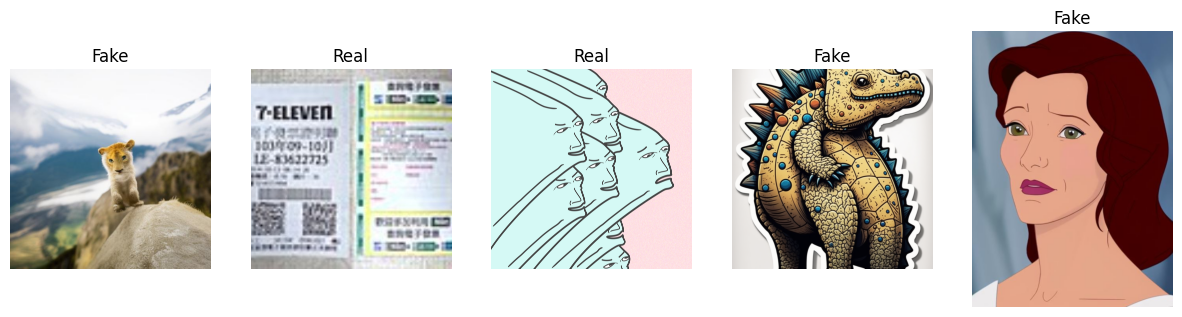

In [7]:
import matplotlib.pyplot as plt
import random

num_images_to_display = 5

if len(file_paths) >= num_images_to_display:
    plt.figure(figsize=(15, 8))
    random_indices = random.sample(range(len(file_paths)), num_images_to_display)

    for i, idx in enumerate(random_indices):
        image_path = file_paths[idx]
        label = labels[idx]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

        # Display image with label
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(img)

        if label == 0:
            plt.title("Fake")
        elif label == 1:
            plt.title("Real")

        plt.axis('off')

    plt.show()
else:
    print("No image files found")

### Data augmentation

In [8]:
img_augmentation_layers = [
    tf.keras.layers.RandomRotation(factor = 0.15),
    tf.keras.layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomContrast(factor = 0.1),
]

### Data preprocessing

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input

# Function to preprocess the data with optional data augmentation and manual normalization
def preprocess_image(file_path, label, augment=False, image_size=(380, 380)):
    # Load and decode image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Ensure 3 channels (RGB)

    # Apply image augmentation if specified
    if augment:
        for layer in img_augmentation_layers:
            img = layer(img)
    # Apply data augmentation if specified and strategy supports it
    # if augment and strategy.num_replicas_in_sync > 1:  # Only augment on replicas > 1
    #     for layer in img_augmentation_layers:
    #         img = strategy.run(lambda: layer(img))


    # Resize image to the required input size for EfficientNetB4
    img = tf.image.resize(img, image_size)

    # Preprocess image using EfficientNet preprocessing
    img = preprocess_input(img)

    # # Manually normalize the preprocessed image to [0, 1] range
    # img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))

    return img, label

the key steps in preprocess input efficientNetb4 :
1. Normalization (centered around zero (mean subtraction) and scales them by dividing by the standard deviation.)
2. Mean subtraction (This helps in centering the pixel values around zero, which is important for training stability and convergence)
3. Channel ordering as EfficientNetB4 inputimages in RGB(Red-Green-Blue) . If the input image is in BGR (Blue-Green-Red) format (common with images loaded using OpenCV), the function performs the necessary conversion to RGB.

4. Scaling (The pixel values are scaled based on the standard deviation computed from the ImageNet dataset.). This step ensures that the input image data falls within a reasonable range that is suitable for the EfficientNetB4 model.


### Data split (train, test and validation)

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets with stratified sampling
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(train_file_paths, train_labels, test_size=0.25, stratify=train_labels, random_state=42)

# Print the length
print("Number of training samples:", len(train_file_paths))
print("Number of training labels:", len(train_labels))
print("Number of validation samples:", len(val_file_paths))
print("Number of validation labels:", len(val_labels))
print("Number of test samples:", len(test_file_paths))
print("Number of test labels:", len(test_labels))


Number of training samples: 4560
Number of training labels: 4560
Number of validation samples: 1520
Number of validation labels: 1520
Number of test samples: 1521
Number of test labels: 1521


In [11]:
# Create TensorFlow datasets for training, validation, and test
train_dataset = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_file_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_file_paths, test_labels))

# Map preprocessing function to the datasets
# Only perform data augmentation on Train dataset
train_dataset = train_dataset.map(lambda x, y: preprocess_image(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: preprocess_image(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: preprocess_image(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch the training dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_file_paths)).batch(batch_size)

# Batch the validation dataset. I wont shuffle and perform data augmentation on  test and vad
val_dataset = val_dataset.batch(batch_size)

# Batch the test dataset
test_dataset = test_dataset.batch(batch_size)

In [11]:
# # Function to display preprocessed image
# def show_preprocessed_images(dataset, num_images=5):
#     plt.figure(figsize=(15, 10))
#     for i, (image, label) in enumerate(dataset.take(1)): # only 1 batch
#         for j in range(num_images):
#             plt.subplot(1, num_images, j + 1)
#             plt.imshow(image[j])  # Display j-th image in the batch
#             plt.title(f"Label: {label[j].numpy()}")
#             plt.axis("off")
#     plt.show()

# # Visualize preprocessed images from the train dataset
# print("Visualizing preprocessed images from the train dataset:")
# show_preprocessed_images(train_dataset)


In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,  ModelCheckpoint

# Load EfficientNetB4 model pre-trained on ImageNet
base_model = tf.keras.applications.EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3)
)

# Freeze the base model layers
base_model.trainable = False

# classification head on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for probability
])

# Compile the model with Adam optimizer and initial learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
# # # Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Model summary
model.summary()


71686520/71686520 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 12, 12, 1792)      17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 1)                 1793      
                                                                 
Total params: 17675616 (67.43 MB)
Trainable params: 1793 (7.00 KB)
Non-trainable params: 17673823 (67.42 MB)
______________

In [13]:
# Train the model with fine-tuning
epochs = 5
model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[reduce_lr])

Epoch 1/5
72/72 [==============================] - 1156s 2s/step - loss: 0.4802 - accuracy: 0.7996 - val_loss: 0.4141 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 2/5
72/72 [==============================] - 842s 1s/step - loss: 0.3341 - accuracy: 0.8844 - val_loss: 0.3653 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 3/5
72/72 [==============================] - 837s 1s/step - loss: 0.2956 - accuracy: 0.8912 - val_loss: 0.3516 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 4/5
72/72 [==============================] - 847s 1s/step - loss: 0.2748 - accuracy: 0.8998 - val_loss: 0.3348 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 5/5
72/72 [==============================] - 842s 1s/step - loss: 0.2620 - accuracy: 0.8985 - val_loss: 0.3336 - val_accuracy: 0.8684 - lr: 0.0010


In [14]:


# Unfreeze the last 20 layers of the base model
fine_tune_at = -20

# Unfreeze the selected layers for fine-tuning
for layer in base_model.layers[fine_tune_at:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Specify a lower learning rate for the fine-tuned layers
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuned layers
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set up a learning rate reduction scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Define ModelCheckpoint callback to save the best model based on validation loss
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_fc.h5',
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # Save the model with the lowest validation loss
    verbose=1
)


In [15]:
# Train the model with fine-tuning
epochs = 20   #recommended 25
model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[reduce_lr , checkpoint_callback])

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.9004
Epoch 1: val_loss improved from inf to 0.33047, saving model to best_model_fc.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 868s 1s/step - loss: 0.2571 - accuracy: 0.9004 - val_loss: 0.3305 - val_accuracy: 0.8717 - lr: 1.0000e-04
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.8982
Epoch 2: val_loss improved from 0.33047 to 0.32939, saving model to best_model_fc.h5
72/72 [==============================] - 852s 1s/step - loss: 0.2616 - accuracy: 0.8982 - val_loss: 0.3294 - val_accuracy: 0.8711 - lr: 1.0000e-04
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.8985
Epoch 3: val_loss did not improve from 0.32939
72/72 [==============================] - 854s 1s/step - loss: 0.2583 - accuracy: 0.8985 - val_loss: 0.3294 - val_accuracy: 0.8711 - lr: 1.0000e-04
Epoch 4/20
72/72 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9026
Epoch 4: val_loss improved from 0.32939 to 0.32817, saving model to best_model_fc.h5
72/72 [==============================] - 848s 1s/step - loss

In [16]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



24/24 [==============================] - 51s 2s/step - loss: 0.3235 - accuracy: 0.8744
Test Loss: 0.32351550459861755
Test Accuracy: 0.8744246959686279


In [17]:

saved_model_path = '/content/drive/My Drive/saved_model'

# Save the model to the specified path
model.save(saved_model_path)